# Import PhiFlow

In [1]:
#from phi.flow import *
from phi.torch.flow import *
import matplotlib.pyplot as plt

# Initialization

In [323]:
DOMAIN = Box(x=math.PI, y=math.PI) # Original Domain Size
S = (50, 50) # Sampling size
DIM = 2

# Number of basis fields
N = 5**2
N_sqrt = int(math.sqrt(N))

# Initialize basis fields
# First, generate the data as a regular array, 
#  with dimensions: N x [k1,k2,eig] = N x 3
# Assume N is a perfect square, and use all basis fields
#  with wave number (k1,k2) up to (sqrt(N), sqrt(N))
def init_basis_fields():
    # (1337 coding):
    #basis_array = [[float(k1), float(k2), -(k1**2 + k2**2)] for k1 in range(1, N_sqrt+1) for k2 in range(1, N_sqrt+1)]
    basis_array = []
    for k1 in range(1, N_sqrt+1):
        for k2 in range(1, N_sqrt+1):
            basis_array.append([k1, k2, -(k1**2 + k2**2)])

    basis_fields = math.tensor(basis_array, instance(i=N), channel(k='k1,k2,eig'))
    return basis_fields

# (k1, k2) -> index in basis_fields tensor
def index_lookup(k1, k2):
    k = tensor([k1, k2], channel(k='k1,k2'))
    for i, f in enumerate(basis_fields.i):
        if all(f['k1,k2'] == k):
            return i
    return -1

# Initialize the w basis field coefficient vecotr
def init_w():
    # 1337
    # w = tensor([1.0 if i == 3 or i==2 or i==5 else 0. for i in range(N)])
    w = []
    for i in range(N):
        if i == 4: w.append(.3)
        elif i == 2: w.append(.3)
        elif i == 6: w.append(.3)
        else: w.append(0)
    w = tensor(w, instance(k=N))
    return w

# scaled by w[i]
def phi(p):
    vel = math.zeros_like(p)
    for i in range(N):
        k1, k2, eig = basis_fields.i[i]
        k1x, k2y = k1*p.vector['x'], k2*p.vector['y']
        # note: we could store this factor
        fact = 2/math.PI/math.sqrt(-eig)
        vel += w[i] * tensor([
            -fact * k2 * math.sin(k1x) * math.cos(k2y),
            +fact * k1 * math.cos(k1x) * math.sin(k2y)
        ], channel(vector='x,y'))
    return vel

# The sampled, discrete current velocity field
# Currently sampling at cell centers
# In the future, maybe sample it in staggered form (https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html)
def reconstruct_velocity():
    #velocity = CenteredGrid((0,0), extrapolation.BOUNDARY, x=S[0], y=S[1], bounds=Box(x=DOMAIN[0], y=DOMAIN[1]))
    velocity = CenteredGrid(phi, extrapolation.BOUNDARY, x=S[0], y=S[1], bounds=DOMAIN)
    return velocity

def init_smoke():
    smoke = CenteredGrid(
        Box(x=[1,2], y=[1,2]), 
        extrapolation.BOUNDARY, 
        x=200, y=200, 
        bounds=DOMAIN
    )
    return smoke

### Precalculate advection tensor/matrix

In [324]:
def precalculate_advection():
    for h in range(N):
        h1, h2, h_eig = basis_fields.i[h]
        for i in range(N):
            i1, i2, i_eig = basis_fields.i[i]
            # the C_k matrices corresponding to these
            # wavelengths are to be updated
            ap = [ # antipairs -- ordered as per the paper, and not the original implementation
                [h1+i1, h2+i2],
                [h1+i1, h2-i2],
                [h1-i1, h2+i2],
                [h1-i1, h2-i2],
            ]
            for c in range(4):
                index = index_lookup(ap[c][0], ap[c][1])
                # discard if wavelength is not in the span of the basis fields
                #if ap[c][0]<N_sqrt and ap[c][1]<N_sqrt:
                if index != -1:
                    coef = coefdensity(h1, h2, i1, i2, c)
                    eig_inv = 1 / basis_fields.i[i][2]
                    coef *= eig_inv
                    # TODO store in sparse matrix
                    C_k[index, h, i] = coef

def coefdensity(h1, h2, i1, i2, c):
    if c == 0: return -0.25 * (h1*h2 - h2*i1)
    if c == 1: return +0.25 * (h1*h2 + h2*i1)
    if c == 2: return -0.25 * (h1*h2 + h2*i1)
    if c == 3: return +0.25 * (h1*h2 - h2*i1)

In [273]:
# Helper for plotting w as a bar plot
def get_w_point_cloud(w):
    x = math.range(instance(bars=N))/N
    bar_heights = stack(w, instance('bars'))
    # to be called inside vis.plot(...)
    return PointCloud(Box(x=(x, x+1/N), y=(0, bar_heights)), bounds=Box(x=(0,1), y=(0,1)))

## Initialize the Simulation

Initialized w = [0.  0.  0.3 0.  0.3 0.  0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0. ]


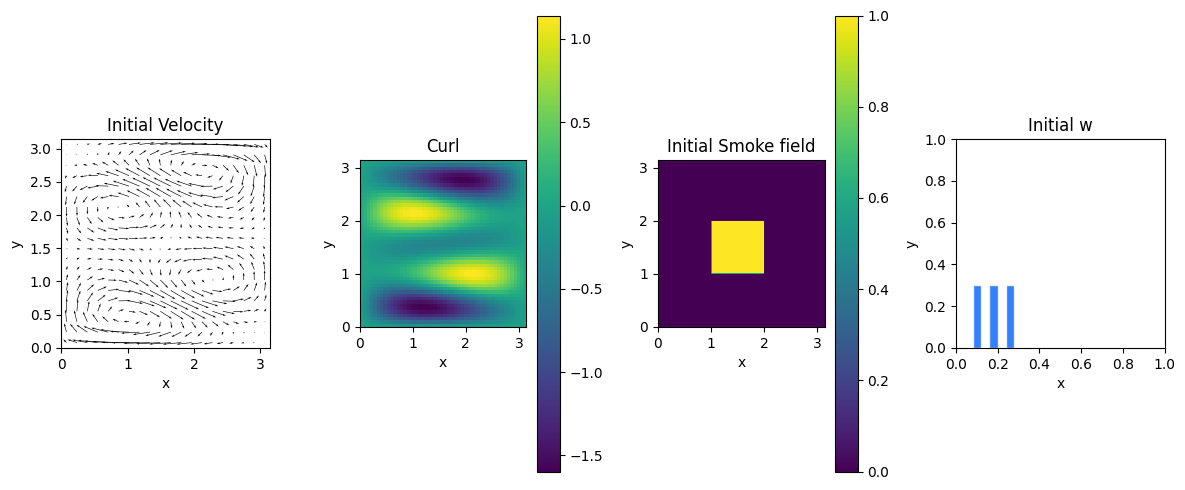

In [325]:
# N x [k1 k2 eig]
basis_fields = init_basis_fields()
#print("Initialized basis_fields:\n{}".format(basis_fields.numpy('i,k')))

w = init_w()
print("Initialized w = {}".format(w.numpy()))

# TODO use sparse matrices
C_k = np.zeros((N,N,N))
precalculate_advection()
C_k = tensor(C_k, instance('k'), channel('h,i'))

velocity = reconstruct_velocity()
smoke = init_smoke()
#vis.plot([velocity, field.curl(velocity)])
# Resampling velocity field on a coarser grid for visualization
if True: vis.plot({
          "Initial Velocity": velocity @ CenteredGrid(0, x=20, y=20, bounds=DOMAIN), 
          "Curl": field.curl(velocity),
          "Initial Smoke field": smoke,
          "Initial w": get_w_point_cloud(w)
         }, same_scale=False)

# Plot w as bars
#print(w.native())
#plt.bar([i for i in range(N)], w.numpy())
#plt.show()

### Update step

In [330]:
def step_w(dt = 0.2, viscosity = 1.):
    global w
    # equivalent loop
    #for k in range(N):
    #    dw = math.dot(math.dot(w, ['k'], C_k.k[k], ['h']), ['i'], w, ['k'])
    dw = math.dot(math.dot(w, ['k'], C_k, ['h']), ['i'], w, ['k'])
    w = w + dw * dt
    eig = basis_fields.k['eig']
    #w *= math.exp(-1.0 * eig * dt * viscosity)

In [331]:
#trajectory = [smoke]
w = init_w()
trajectory = [velocity]
for i in range(200):
    step_w(dt = .1)
    velocity = reconstruct_velocity()
    trajectory.append(velocity)
    #smoke = advect.mac_cormack(smoke, velocity, dt=.5)
    #trajectory.append(smoke)

trajectory = field.stack(trajectory, batch('time'))
#vis.plot([velocity * 0.2, field.curl(velocity), trajectory], animate='time')
vis.plot([trajectory, field.curl(trajectory)], animate='time')

<Figure size 640x480 with 0 Axes>